In [6]:

import argparse
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def find_hough_lines(image, edge_image, num_rhos, num_thetas, bin_threshold):
  #image size
  img_height, img_width = edge_image.shape[:2]
  img_height_half = img_height / 2
  img_width_half = img_width / 2
  
  # Rho and Theta ranges
  diag_len = np.sqrt(np.square(img_height) + np.square(img_width))
  dtheta = 180 / num_thetas
  drho = (2 * diag_len) / num_rhos
  
  ## Thetas is bins created from 0 to 180 degree with increment of the provided dtheta
  thetas = np.arange(0, 180, step=dtheta)
  
  ## Rho ranges from -diag_len to diag_len where diag_len is the diagonal length of the input image
  rhos = np.arange(-diag_len, diag_len, step=drho)
  
  # Calculate Cos(theta) and Sin(theta) it will be required later on while calculating rho
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  
  # Hough accumulator array of theta vs rho, (rho,theta)
  accumulator = np.zeros((len(rhos), len(thetas)))
  
  # Hough Space plot for the image.
  figure = plt.figure()
  hough_plot = figure.add_subplot()
  hough_plot.set_facecolor((0, 0, 0))
  hough_plot.title.set_text("Hough Space")
  
  # Iterate through pixels and if non-zero pixel process it for hough space
  for y in range(img_height):
    for x in range(img_width):
      if edge_image[y][x] != 0: #white pixel
        edge_pt = [y - img_height_half, x - img_width_half]
        hough_rhos, hough_thetas = [], [] 
        
        # Iterate through theta ranges to calculate the rho values
        for theta_idx in range(len(thetas)):
          # Calculate rho value
          rho = (edge_pt[1] * cos_thetas[theta_idx]) + (edge_pt[0] * sin_thetas[theta_idx])
          theta = thetas[theta_idx]
          
          # Get index of nearest rho value
          rho_idx = np.argmin(np.abs(rhos - rho))
          
          #increment the vote for (rho_idx,theta_idx) pair
          accumulator[rho_idx][theta_idx] += 1
          
          # Append values of rho and theta in hough_rhos and hough_thetas respectively for Hough Space plotting.
          hough_rhos.append(rho)
          hough_thetas.append(theta)
        
        # Plot Hough Space from the values
        hough_plot.plot(hough_thetas, hough_rhos, color="white", alpha=0.05)

  # accumulator, thetas, rhos are calculated for entire image, Now return only the ones which have higher votes. 
  # if required all can be returned here, the below code could be post processing done by the user.
  
  # Output image with detected lines drawn
  output_img = image.copy()
  # Output list of detected lines. A single line would be a tuple of (rho,theta,x1,y1,x2,y2) 
  out_lines = []
  
  for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      # If number of votes is greater than bin_threshold provided shortlist it as a candidate line
      if accumulator[y][x] > bin_threshold:
        rho = rhos[y]
        theta = thetas[x]
        
        # a and b are intercepts in x and y direction
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        
        x0 = (a * rho) + img_width_half
        y0 = (b * rho) + img_height_half
        
        # Get the extreme points to draw the line
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        
        # Plot the Maxima point on the Hough Space Plot
        hough_plot.plot([theta], [rho], marker='o', color="yellow")
        
        # Draw line on the output image
        output_img = cv2.line(output_img, (x1,y1), (x2,y2), (0,255,0), 1)
        
        # Add the data for the line to output list
        out_lines.append((rho,theta,x1,y1,x2,y2))

  # Show the Hough plot
  hough_plot.invert_yaxis()
  hough_plot.invert_xaxis()
  plt.show()
  
  return output_img, out_lines, accumulator, thetas, rhos

def peak_votes(accumulator, thetas, rhos):
    """ Finds the max number of votes in the hough accumulator """
    idx = np.argmax(accumulator)
    rho = rhos[int(idx / accumulator.shape[1])]
    theta = thetas[idx % accumulator.shape[1]]

    return idx, theta, rho


def theta2gradient(theta):
    """ Finds slope m from theta """
    return np.cos(theta) / np.sin(theta)


def rho2intercept(theta, rho):
    """ Finds intercept b from rho """
    return rho / np.sin(theta)


Detecting Hough Lines Started!


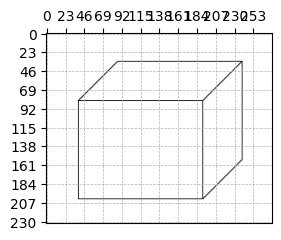

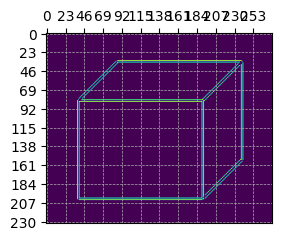

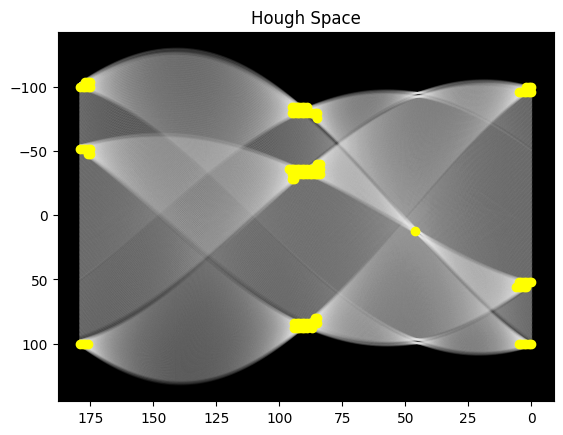

[(-104.1603701800708, 175.0, 154, -889, 328, 1103), (-104.1603701800708, 176.0, 172, -888, 311, 1106), (-104.1603701800708, 177.0, 189, -888, 294, 1109), (-100.15420209622192, 0.0, 37, 1116, 37, -884), (-100.15420209622192, 1.0, 20, 1114, 55, -885), (-100.15420209622192, 2.0, 3, 1111, 72, -886), (-100.15420209622192, 175.0, 150, -888, 324, 1103), (-100.15420209622192, 176.0, 168, -888, 307, 1106), (-100.15420209622192, 177.0, 185, -887, 290, 1109), (-100.15420209622192, 178.0, 203, -886, 272, 1111), (-100.15420209622192, 179.0, 220, -885, 255, 1114), (-96.14803401237305, 0.0, 41, 1116, 41, -884), (-96.14803401237305, 1.0, 24, 1114, 59, -885), (-96.14803401237305, 2.0, 7, 1112, 76, -886), (-96.14803401237305, 3.0, -10, 1109, 94, -887), (-96.14803401237305, 4.0, -27, 1106, 111, -888), (-96.14803401237305, 5.0, -44, 1103, 129, -888), (-84.12952976082641, 89.0, -863, 49, 1136, 14), (-84.12952976082641, 90.0, -862, 31, 1138, 31), (-84.12952976082641, 91.0, -860, 14, 1139, 49), (-84.12952976

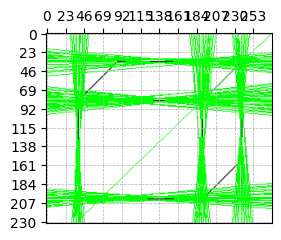

In [13]:
imgpath = 'cube1.jpg'
num_rho = 180
num_theta = 180
bin_threshold = 100
lines_are_white = True

input_img = cv2.imread(imgpath)
show1Image(input_img)

#Edge detection on the input image
edge_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
ret, edge_image = cv2.threshold(edge_image, 120, 255, cv2.THRESH_BINARY_INV)
edge_image = cv2.Canny(edge_image, 100, 200)

show1Image(edge_image)

print ("Detecting Hough Lines Started!")
line_img, lines, accumulator, thetas, rhos = find_hough_lines(input_img, edge_image, num_rho, num_theta, bin_threshold)
print(lines)

show1Image(line_img)
print(peak_votes(accumulator, thetas, rhos))
        
print ("Detecting Hough Lines Complete!")


In [8]:
def show1Image(base):
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    plt.imshow(base)
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.xaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.yaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle='--', linewidth=0.25)

def show2Images(base, conv):
    f = plt.figure()
    plt.tight_layout()
    f.add_subplot(1, 2, 1)
    plt.imshow(base)
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.xaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.yaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle='--', linewidth=0.25)
    f.add_subplot(1, 2, 2)
    plt.imshow(conv)

    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.xaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.yaxis.set_major_locator(MultipleLocator(int(base.shape[0]/10)))
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle='--', linewidth=0.25)
    plt.show(block=True)

def show3Images(img1, img2, img3):
        
    # Create a figure
    fig = plt.figure()  # Adjust the figsize as needed

    # Add three subplots in a horizontal layout
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    # Plot the images in the subplots
    ax1.imshow(img1, cmap='gray')  # Replace 'gray' with the desired colormap
    ax1.grid(which='major', linestyle='--', linewidth=0.5)
    ax1.grid(which='minor', linestyle='--', linewidth=0.25)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))
    ax1.yaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))

    ax2.imshow(img2, cmap='gray')
    ax2.grid(which='major', linestyle='--', linewidth=0.5)
    ax2.grid(which='minor', linestyle='--', linewidth=0.25)
    ax2.xaxis.tick_top()
    ax2.xaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))
    ax2.yaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))

    ax3.imshow(img3, cmap='gray')
    ax3.grid(which='major', linestyle='--', linewidth=0.5)
    ax3.grid(which='minor', linestyle='--', linewidth=0.25)
    ax3.xaxis.tick_top()
    ax3.xaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))
    ax3.yaxis.set_major_locator(MultipleLocator(int(img3.shape[0]/8)))

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the figure
    plt.show()